In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.functional import kl_divergence


# **Introduction and Problem Statement:**

Generative AI has made significant strides in creating realistic images, with diffusion models emerging as a powerful approach in this domain. Diffusion models, which gradually transform a simple noise distribution into complex data distributions, have demonstrated remarkable capabilities in generating high-quality images. This project aims to build a diffusion model from scratch, specifically tailored to generate realistic images of cars. By training the model on the Stanford Cars Dataset, we aim to produce a generative image model that can create new car images, providing a deeper understanding of the mechanics of diffusion models and contributing to advancements in generative AI.

# **Task and Motivation:**

The primary task of this project is to develop a generative image model using a diffusion approach and train the model on SatndordCars Dataset to generate new car images. The motivation behind this project is to evaluate the effectiveness of diffusion models in generating realistic images compared to GAN models. By calculating metrics such as FID (Fréchet Inception Distance), IS (Inception Score), and KL divergence during the training process, we aim to assess the quality of images generated by diffusion models and identify which parameters play a decisive role in image quality. Furthermore, we have improved upon the unconditional model by dividing the car dataset into 25 categories and establishing a conditional diffusion model. Using these metrics, we will determine whether this approach enhances the quality of the generated images. Those evaluations will provide insights into the strengths and limitations of diffusion models and help refine their implementation for better generative performance.

# **Exploratory Analysis of Data**
## **Properties of the Dataset:**
•	Dataset Used: Portion Stanford Cars Dataset

•	Total Images: 2000

•	Images classes: 25 (first 16 classes as output)

•	real Images (used for calculating FID): 2000

## **Pre-processing Steps:**
1.	Resizing: Images were resized to (80x80) pixels and then randomly cropped to (24x24) pixels to maintain variation and augment the training data.

2.	Normalization: Normalization is a crucial step in the pre-processing pipeline, aimed at scaling the pixel values of the images to a standard range. Images were normalized to have a mean of (0.5, 0.5, 0.5) and a standard deviation of (0.5, 0.5, 0.5). This normalization process ensures that the data is in a consistent range, reducing the risk of numerical instabilities during training.

3.  Classify：Split the image data into 25 classes according to their label, each class has 89 images

## **Challenging Aspects:**

Because the amount of data for each class is very small, only 89 images, adding the category information to the model may cause the model to learn no useful information about the category

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        batch_size, _, height, width = x.shape
        size = height * width

        x = x.view(batch_size, self.channels, size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(batch_size, self.channels, height, width)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=25, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 6)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 12)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 24)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

# **Models and/or Methods:**

## **Source and Contributions:**
•	**Source**: The foundational code and approach for the diffusion model were inspired by the repository https://github.com/dome272/Diffusion-Models-pytorch

•	**Own Work**: My primary contributions include integrating the diffusion model with the coditional U-Net architecture, developing the training function to ensure image generation at the end of each training session, logging training metrics, and calculating FID, IS, and KL Divergence scores and implementing the visualization of these metrics by plotting the respective curves.


The primary model used in this project is a conditional U-Net architecture, which is enhanced with self-attention mechanisms and positional encoding for time steps. The model is trained using a diffusion process to generate high-quality images of cars. The implementation details are as follows:
1.	**Double Convolution** (DoubleConv):

	This module consists of two convolutional layers with Group Normalization and GELU activation functions. It can be configured to use residual connections for improved training stability.
2.	**Downsampling** (Down):

	This module applies max pooling followed by double convolution layers to reduce the spatial dimensions of the input. It also includes an embedding layer to incorporate time step information.
3.	**Upsampling** (Up):

	This module upsamples the input using bilinear interpolation, followed by double convolution layers. It concatenates the upsampled input with skip connections from the corresponding downsampling layers. It also incorporates time step information using an embedding layer.
4.	**Self-Attention** (SelfAttention):

	Self-attention mechanisms are integrated at multiple stages in the U-Net to capture long-range dependencies and improve the quality of generated images.
5.	**U-Net Conditional**: referenced by  https://github.com/dome272/Diffusion-Models-pytorch

	The `UNet_conditional` model is a variant of the U-Net model that includes additional mechanisms for conditional generation. It is composed of an initial convolution layer (inc), three downsampling layers (down1, down2, down3) with self-attention, a bottleneck section with double convolutions, and three upsampling layers (up1, up2, up3) with self-attention. The model also incorporates a time-step embedding and class label embedding, which are added to the positional encodings at each layer. The final output layer (outc) generates the output image, conditioned on both the time-step and class label.
	
6.	**Positional Encoding**:

	Positional encoding is used to incorporate time step information into the model. This is done by generating sinusoidal embeddings based on the time step values.

In [ ]:
def plot_images(images):
    # check
    if images.dtype == torch.uint8:
        images = images.float() / 255.0

    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)


def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(30),  
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader


def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

def calculate_inception_score(images, batch_size=32, device='cuda'):
    inception = InceptionScore().to(device)
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        inception.update(batch_images)

    is_value, is_std = inception.compute()
    inception.reset()

    return is_value, is_std

# **Diffusion Process:**
The Diffusion class encapsulates the diffusion process. The main components of the diffusion process include the noise schedule, the noise addition mechanism, and the sampling procedure. The goal is to train the model to predict and reverse the added noise step-by-step to generate high-quality images from pure noise.


1.   **Noise Schedule**:

  The noise schedule defines how noise is gradually added to the images over a fixed number of steps (noise_steps). This is controlled by two parameters, beta_start and beta_end, which represent the starting and ending values of the noise variance. In this implementation, prepare_noise_schedule creates a linear schedule of noise values from beta_start to beta_end over noise_steps. The alpha values are then calculated as 1 - beta, and alpha_hat is the cumulative product of alpha values, which is used in subsequent calculations.
2.   **Noise Addition:**

  At each step of the diffusion process, noise is added to the images. The function noise_images handles this by calculating the weighted sum of the image and the noise at each timestep t.Here, sqrt_alpha_hat and sqrt_one_minus_alpha_hat are used to scale the image and noise, respectively. The function returns the noisy image and the added noise.
  
3.  **Sampling Timesteps:**

  During training and image generation, timesteps are sampled randomly to ensure the model learns to denoise images at various stages of the diffusion process.

4.  **Image Sampling:**

  The sample function generates new images by reversing the noise addition process. Starting from pure noise, the model iteratively refines the image by removing the predicted noise.
  The model starts with a random noise image x.For each timestep t, the model predicts the noise component predicted_noise.The image is refined by removing the predicted noise and adding a new noise component if necessary.The final image is scaled back to the [0, 255] range and converted to an integer format.

In [ ]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=24, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

# **Training Methodology:**
1.	**Diffusion Process:**

	The diffusion model is trained using a noise schedule, which gradually transforms random noise into a realistic image. The model learns to predict the noise added at each step, allowing it to generate high-quality images from pure noise.
2.	**Loss Function:**

	The Mean Squared Error (MSE) loss is used to measure the difference between the predicted noise and the actual noise added during the diffusion process.

3. **log metrics**

 Implementing logger.add_scalar function adds scalar values to the log, used when training neural networks, to visualize various metrics during training in tools such as TensorBoard.

## **Metrics Implementation:**

 **FID Calculation:**

Evaluates the distance between the generated images and real images in the feature space.
Provides insights into the overall sample quality and diversity of the generated images.


**Inception Score Calculation:**

Measures the quality and diversity of the generated images.
Focuses on how well the generated images resemble the training data in terms of class distribution.

**KL Divergence Calculation:**

Assesses the difference between the predicted noise distribution and the actual noise distribution.
Helps in understanding the alignment of the generated data distribution with the expected distribution.


Perform index method referenced by https://blog.csdn.net/jackzhang11/article/details/104995524

# Inception Score

The Inception Score (IS) evaluates the quality and diversity of generated images based on the output of a pretrained Inception network. It is calculated as follows:

$
IS(G) = \exp \left( \mathbb{E}_{\mathbf{x} \sim p_g} \left[ D_{KL}( p(y|\mathbf{x}) \parallel p(y) ) \right] \right)
$

Where:

$
D_{KL}( p(y|\mathbf{x}) \parallel p(y) ) = \sum_{i} p(y_i|\mathbf{x}) \log \frac{p(y_i|\mathbf{x})}{p(y_i)}
$

- $ \mathbf{x} \sim p_g $ denotes that the images $ \mathbf{x} $ are sampled from the model distribution $ p_g $.
- $ p(y|\mathbf{x}) $ is the conditional label distribution given by the Inception network.
- $ p(y) $ is the marginal class distribution, which is the mean of $ p(y|\mathbf{x}) $ over all generated images.
- $ D_{KL} $ is the Kullback-Leibler divergence.

During the calculation process, we initialize the Inception Score calculator and set it to the specified device (GPU). Split the image collection into multiple batches based on batch size. Then we update the Inception Score calculator batch by batch. Finally, we calculate and return the mean and standard deviation of the Inception Score, while resetting the calculator state

# FID

The Fréchet Inception Distance (FID) measures the distance between the feature vectors of real and generated images. It uses the mean and covariance of these feature vectors to compute the Wasserstein-2 distance between two multivariate Gaussians.

$
FID = \| \mu_r - \mu_g \|_2^2 + \operatorname{Tr}(C_r + C_g - 2(C_r C_g)^{1/2})
$

Where:

$
\| \mu_r - \mu_g \|_2^2 = \sum_{i} (\mu_{r_i} - \mu_{g_i})^2
$

- $ \mu_r $ and $ \mu_g $ are the mean feature vectors of the real and generated images, respectively.
- $ C_r $ and $ C_g $ are the covariance matrices of the real and generated images, respectively.
- $ \operatorname{Tr} $ denotes the trace of a matrix.

We directly called the FrechetInceptionDistance in the torchmetrics.image.fid library in the code to calculate our fid value.


In [ ]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet_conditional(num_classes=args.num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    # Initialize InceptionScore and FID
    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    # Arrays to store metrics
    epochs_recorded = []
    fid_values = []
    is_values = []
    kl_div_values = []
    mse_values = []

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        epoch_loss = 0  # Initialize epoch loss
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)
            epoch_loss += loss.item()  # Accumulate loss for the epoch

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)




        # Average the epoch loss
        epoch_loss /= len(dataloader)

        #After each epoch, sample and calculate metrics
        labels = torch.arange(16).long().to(device)
        sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
        real_images = next(iter(dataloader))[0].to(device)[:len(labels)]

        # save images

        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
        torch.save(optimizer.state_dict(), os.path.join("models", args.run_name, f"optim.pt"))

        # Convert images to uint8 for saving (not for metric calculation)
        sampled_images_uint8 = (sampled_images.clamp(0, 1) * 255).to(torch.uint8)
        real_images_uint8 = (real_images.clamp(0, 1) * 255).to(torch.uint8)

        # Calculate IS
        is_value, is_std = calculate_inception_score(sampled_images_uint8)
        print(f"Inception Score: {is_value.item()} ± {is_std.item()}")
        # Calculate FID
        fid.update(sampled_images_uint8, real=False)  # Use original floating-point images
        fid.update(real_images_uint8, real=True)
        fid_value = fid.compute().item()
        fid.reset()
        print(f"FID: {fid_value}")
        # Reshape predicted_noise and noise for KL Divergence calculation
        predicted_noise_2d = predicted_noise.reshape(predicted_noise.size(0), -1)
        noise_2d = noise.reshape(noise.size(0), -1)

        # Calculate KL Divergence
        kl_value = kl_divergence(predicted_noise_2d.softmax(dim=-1), noise_2d.softmax(dim=-1)).item()

        # Store metrics
        epochs_recorded.append(epoch)
        fid_values.append(fid_value)
        is_values.append((is_value.item(), is_std.item()))
        kl_div_values.append(kl_value)
        mse_values.append(epoch_loss)  # Record epoch loss
        # Print additional parameters
        print(f"Epoch [{epoch}/{args.epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item()}, Learning Rate: {optimizer.param_groups[0]['lr']}")


    # Plot metrics after training
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_recorded, mse_values, label='MSE Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    is_mean = [x[0] for x in is_values]
    is_std = [x[1] for x in is_values]
    plt.plot(epochs_recorded, is_mean, label='Inception Score')
    plt.fill_between(epochs_recorded, [m - s for m, s in zip(is_mean, is_std)], [m + s for m, s in zip(is_mean, is_std)], alpha=0.3)
    plt.xlabel('Epochs')
    plt.ylabel('Inception Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_recorded, fid_values, label='FID')
    plt.xlabel('Epochs')
    plt.ylabel('FID')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_recorded, kl_div_values, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final values of metrics
    print(f"Final MSE Loss: {mse_values[-1]}")
    print(f"Final Inception Score: {is_values[-1][0]} ± {is_values[-1][1]}")
    print(f"Final FID: {fid_values[-1]}")
    print(f"Final KL Divergence: {kl_div_values[-1]}")

100%|██████████| 63/63 [00:05<00:00, 10.66it/s, MSE=0.0214]
04:38:25 - INFO: Sampling 16 new images....
999it [00:18, 53.10it/s]


Inception Score: 1.1451802253723145 ± 0.27096933126449585


04:38:47 - INFO: Starting epoch 416:


FID: 440.614013671875
Epoch [415/500], Step [62/63], Loss: 0.021380413323640823, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.89it/s, MSE=0.029] 
04:38:52 - INFO: Sampling 16 new images....
999it [00:17, 56.06it/s]


Inception Score: 1.0584957599639893 ± 0.06615346670150757


04:39:13 - INFO: Starting epoch 417:


FID: 453.3150939941406
Epoch [416/500], Step [62/63], Loss: 0.028971830382943153, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.82it/s, MSE=0.011] 
04:39:19 - INFO: Sampling 16 new images....
999it [00:17, 56.06it/s]


Inception Score: 1.2502360343933105 ± 0.16752317547798157


04:39:40 - INFO: Starting epoch 418:


FID: 458.7781066894531
Epoch [417/500], Step [62/63], Loss: 0.010960126295685768, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.96it/s, MSE=0.0385] 
04:39:46 - INFO: Sampling 16 new images....
999it [00:17, 56.43it/s]


Inception Score: 1.1453148126602173 ± 0.19693081080913544


04:40:07 - INFO: Starting epoch 419:


FID: 483.7292175292969
Epoch [418/500], Step [62/63], Loss: 0.038476355373859406, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.90it/s, MSE=0.0219]
04:40:13 - INFO: Sampling 16 new images....
999it [00:17, 55.56it/s]


Inception Score: 1.0708305835723877 ± 0.06188388168811798


04:40:34 - INFO: Starting epoch 420:


FID: 462.88720703125
Epoch [419/500], Step [62/63], Loss: 0.02190893515944481, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.88it/s, MSE=0.0117]
04:40:40 - INFO: Sampling 16 new images....
999it [00:17, 55.53it/s]


Inception Score: 1.0860096216201782 ± 0.1057550311088562


04:41:01 - INFO: Starting epoch 421:


FID: 481.4454345703125
Epoch [420/500], Step [62/63], Loss: 0.011729728430509567, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.83it/s, MSE=0.0243]
04:41:07 - INFO: Sampling 16 new images....
999it [00:17, 56.87it/s]


Inception Score: 1.0611951351165771 ± 0.06742728501558304


04:41:28 - INFO: Starting epoch 422:


FID: 492.05645751953125
Epoch [421/500], Step [62/63], Loss: 0.024262776598334312, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.87it/s, MSE=0.0119] 
04:41:34 - INFO: Sampling 16 new images....
999it [00:17, 55.69it/s]


Inception Score: 1.1325578689575195 ± 0.10186608880758286


04:41:55 - INFO: Starting epoch 423:


FID: 439.2125549316406
Epoch [422/500], Step [62/63], Loss: 0.011919145472347736, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.90it/s, MSE=0.0103]
04:42:01 - INFO: Sampling 16 new images....
999it [00:17, 55.99it/s]


Inception Score: 1.2012546062469482 ± 0.15497583150863647


04:42:22 - INFO: Starting epoch 424:


FID: 436.2929382324219
Epoch [423/500], Step [62/63], Loss: 0.010257339105010033, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.81it/s, MSE=0.0235] 
04:42:28 - INFO: Sampling 16 new images....
999it [00:17, 56.06it/s]


Inception Score: 1.190842628479004 ± 0.23777784407138824


04:42:49 - INFO: Starting epoch 425:


FID: 435.162841796875
Epoch [424/500], Step [62/63], Loss: 0.02354583702981472, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.54it/s, MSE=0.0243]
04:42:55 - INFO: Sampling 16 new images....
999it [00:17, 56.53it/s]


Inception Score: 1.2031320333480835 ± 0.16448242962360382


04:43:16 - INFO: Starting epoch 426:


FID: 405.0634460449219
Epoch [425/500], Step [62/63], Loss: 0.024345381185412407, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.0198]
04:43:22 - INFO: Sampling 16 new images....
999it [00:17, 56.12it/s]


Inception Score: 1.2064902782440186 ± 0.11714852601289749


04:43:43 - INFO: Starting epoch 427:


FID: 358.2990417480469
Epoch [426/500], Step [62/63], Loss: 0.019804703071713448, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.86it/s, MSE=0.0206] 
04:43:49 - INFO: Sampling 16 new images....
999it [00:17, 55.71it/s]


Inception Score: 1.120343804359436 ± 0.11074716597795486


04:44:10 - INFO: Starting epoch 428:


FID: 468.87835693359375
Epoch [427/500], Step [62/63], Loss: 0.02059374935925007, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.86it/s, MSE=0.0121] 
04:44:16 - INFO: Sampling 16 new images....
999it [00:17, 56.92it/s]


Inception Score: 1.183679223060608 ± 0.20933102071285248


04:44:37 - INFO: Starting epoch 429:


FID: 464.2286071777344
Epoch [428/500], Step [62/63], Loss: 0.012109062634408474, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.82it/s, MSE=0.0121] 
04:44:42 - INFO: Sampling 16 new images....
999it [00:17, 55.56it/s]


Inception Score: 1.156965970993042 ± 0.1595994085073471


04:45:03 - INFO: Starting epoch 430:


FID: 484.1574401855469
Epoch [429/500], Step [62/63], Loss: 0.012117922306060791, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.75it/s, MSE=0.0225]
04:45:09 - INFO: Sampling 16 new images....
999it [00:17, 56.33it/s]


Inception Score: 1.2207157611846924 ± 0.14240418374538422


04:45:30 - INFO: Starting epoch 431:


FID: 433.5764465332031
Epoch [430/500], Step [62/63], Loss: 0.02252011001110077, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0123] 
04:45:36 - INFO: Sampling 16 new images....
999it [00:17, 56.84it/s]


Inception Score: 1.187378168106079 ± 0.11647328734397888


04:45:57 - INFO: Starting epoch 432:


FID: 450.625732421875
Epoch [431/500], Step [62/63], Loss: 0.012323722243309021, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.88it/s, MSE=0.0107] 
04:46:03 - INFO: Sampling 16 new images....
999it [00:17, 56.12it/s]


Inception Score: 1.2414002418518066 ± 0.2217024564743042


04:46:24 - INFO: Starting epoch 433:


FID: 403.0116271972656
Epoch [432/500], Step [62/63], Loss: 0.01068561989814043, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.98it/s, MSE=0.0186]
04:46:30 - INFO: Sampling 16 new images....
999it [00:17, 56.59it/s]


Inception Score: 1.234795093536377 ± 0.23103466629981995


04:46:51 - INFO: Starting epoch 434:


FID: 418.3539733886719
Epoch [433/500], Step [62/63], Loss: 0.01860453002154827, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0305]
04:46:57 - INFO: Sampling 16 new images....
999it [00:17, 55.67it/s]


Inception Score: 1.051572561264038 ± 0.10569367557764053


04:47:18 - INFO: Starting epoch 435:


FID: 455.9780578613281
Epoch [434/500], Step [62/63], Loss: 0.03046046383678913, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.88it/s, MSE=0.0246]
04:47:23 - INFO: Sampling 16 new images....
999it [00:17, 56.30it/s]


Inception Score: 1.060135841369629 ± 0.0768960565328598


04:47:44 - INFO: Starting epoch 436:


FID: 530.4431762695312
Epoch [435/500], Step [62/63], Loss: 0.024622667580842972, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.81it/s, MSE=0.0174]
04:47:50 - INFO: Sampling 16 new images....
999it [00:17, 56.11it/s]


Inception Score: 1.1494548320770264 ± 0.18822592496871948


04:48:11 - INFO: Starting epoch 437:


FID: 510.072021484375
Epoch [436/500], Step [62/63], Loss: 0.017403163015842438, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.80it/s, MSE=0.0215]
04:48:17 - INFO: Sampling 16 new images....
999it [00:17, 56.77it/s]


Inception Score: 1.2552950382232666 ± 0.21116091310977936


04:48:38 - INFO: Starting epoch 438:


FID: 474.7383117675781
Epoch [437/500], Step [62/63], Loss: 0.021526427939534187, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.96it/s, MSE=0.0197] 
04:48:44 - INFO: Sampling 16 new images....
999it [00:17, 56.64it/s]


Inception Score: 1.166043996810913 ± 0.13276438415050507


04:49:05 - INFO: Starting epoch 439:


FID: 446.4031982421875
Epoch [438/500], Step [62/63], Loss: 0.019673286005854607, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.88it/s, MSE=0.0188]
04:49:11 - INFO: Sampling 16 new images....
999it [00:17, 56.36it/s]


Inception Score: 1.0337679386138916 ± 0.06294269114732742


04:49:32 - INFO: Starting epoch 440:


FID: 489.4992980957031
Epoch [439/500], Step [62/63], Loss: 0.018798405304551125, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.97it/s, MSE=0.0194]
04:49:38 - INFO: Sampling 16 new images....
999it [00:17, 56.35it/s]


Inception Score: 1.1170690059661865 ± 0.07729560881853104


04:49:59 - INFO: Starting epoch 441:


FID: 464.0902099609375
Epoch [440/500], Step [62/63], Loss: 0.019350256770849228, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.92it/s, MSE=0.0249]
04:50:05 - INFO: Sampling 16 new images....
999it [00:17, 56.99it/s]


Inception Score: 1.079972505569458 ± 0.07544579356908798


04:50:25 - INFO: Starting epoch 442:


FID: 437.7861633300781
Epoch [441/500], Step [62/63], Loss: 0.024920782074332237, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.80it/s, MSE=0.0177]
04:50:31 - INFO: Sampling 16 new images....
999it [00:17, 56.53it/s]


Inception Score: 1.0407031774520874 ± 0.06043114885687828


04:50:52 - INFO: Starting epoch 443:


FID: 503.2148742675781
Epoch [442/500], Step [62/63], Loss: 0.01769082061946392, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.85it/s, MSE=0.0171]
04:50:58 - INFO: Sampling 16 new images....
999it [00:17, 55.80it/s]


Inception Score: 1.2120065689086914 ± 0.14740830659866333


04:51:19 - INFO: Starting epoch 444:


FID: 389.9934387207031
Epoch [443/500], Step [62/63], Loss: 0.01708606816828251, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.92it/s, MSE=0.0349]
04:51:25 - INFO: Sampling 16 new images....
999it [00:17, 56.19it/s]


Inception Score: 1.1669745445251465 ± 0.2061316967010498


04:51:46 - INFO: Starting epoch 445:


FID: 440.67413330078125
Epoch [444/500], Step [62/63], Loss: 0.03492720052599907, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.87it/s, MSE=0.022] 
04:51:52 - INFO: Sampling 16 new images....
999it [00:17, 56.37it/s]


Inception Score: 1.2634848356246948 ± 0.18432408571243286


04:52:13 - INFO: Starting epoch 446:


FID: 431.6886901855469
Epoch [445/500], Step [62/63], Loss: 0.0220025684684515, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.84it/s, MSE=0.0262] 
04:52:19 - INFO: Sampling 16 new images....
999it [00:18, 55.27it/s]


Inception Score: 1.0809388160705566 ± 0.1318833976984024


04:52:40 - INFO: Starting epoch 447:


FID: 528.1795043945312
Epoch [446/500], Step [62/63], Loss: 0.026227792724967003, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.81it/s, MSE=0.0112]
04:52:46 - INFO: Sampling 16 new images....
999it [00:17, 56.56it/s]


Inception Score: 1.1568281650543213 ± 0.12400727719068527


04:53:07 - INFO: Starting epoch 448:


FID: 413.21453857421875
Epoch [447/500], Step [62/63], Loss: 0.011192750185728073, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.0181] 
04:53:12 - INFO: Sampling 16 new images....
999it [00:17, 55.84it/s]


Inception Score: 1.1157691478729248 ± 0.11818390339612961


04:53:34 - INFO: Starting epoch 449:


FID: 439.0584716796875
Epoch [448/500], Step [62/63], Loss: 0.018146630376577377, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.84it/s, MSE=0.0612] 
04:53:39 - INFO: Sampling 16 new images....
999it [00:17, 56.41it/s]


Inception Score: 1.1584346294403076 ± 0.10105526447296143


04:54:00 - INFO: Starting epoch 450:


FID: 472.2541809082031
Epoch [449/500], Step [62/63], Loss: 0.061222415417432785, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.86it/s, MSE=0.0156] 
04:54:06 - INFO: Sampling 16 new images....
999it [00:17, 55.83it/s]


Inception Score: 1.093489646911621 ± 0.14278672635555267


04:54:27 - INFO: Starting epoch 451:


FID: 463.188232421875
Epoch [450/500], Step [62/63], Loss: 0.015570183284580708, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.83it/s, MSE=0.0423]
04:54:33 - INFO: Sampling 16 new images....
999it [00:17, 56.00it/s]


Inception Score: 1.023493766784668 ± 0.04367465153336525


04:54:54 - INFO: Starting epoch 452:


FID: 494.78118896484375
Epoch [451/500], Step [62/63], Loss: 0.04228523001074791, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.0186] 
04:54:59 - INFO: Sampling 16 new images....
999it [00:17, 56.47it/s]


Inception Score: 1.1314581632614136 ± 0.1269214153289795


04:55:20 - INFO: Starting epoch 453:


FID: 477.34716796875
Epoch [452/500], Step [62/63], Loss: 0.018595300614833832, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.97it/s, MSE=0.0236]
04:55:26 - INFO: Sampling 16 new images....
999it [00:17, 55.94it/s]


Inception Score: 1.1462364196777344 ± 0.08726061880588531


04:55:47 - INFO: Starting epoch 454:


FID: 474.0525207519531
Epoch [453/500], Step [62/63], Loss: 0.023624883964657784, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0264]
04:55:53 - INFO: Sampling 16 new images....
999it [00:17, 56.41it/s]


Inception Score: 1.2258737087249756 ± 0.15496878325939178


04:56:14 - INFO: Starting epoch 455:


FID: 414.890869140625
Epoch [454/500], Step [62/63], Loss: 0.026410473510622978, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.03it/s, MSE=0.0223]
04:56:20 - INFO: Sampling 16 new images....
999it [00:17, 56.10it/s]


Inception Score: 1.1433008909225464 ± 0.09218284487724304


04:56:41 - INFO: Starting epoch 456:


FID: 454.1819763183594
Epoch [455/500], Step [62/63], Loss: 0.022339750081300735, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.96it/s, MSE=0.0156] 
04:56:47 - INFO: Sampling 16 new images....
999it [00:17, 56.30it/s]


Inception Score: 1.0270788669586182 ± 0.07659115642309189


04:57:08 - INFO: Starting epoch 457:


FID: 505.7338562011719
Epoch [456/500], Step [62/63], Loss: 0.01564810611307621, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.80it/s, MSE=0.0201]
04:57:13 - INFO: Sampling 16 new images....
999it [00:17, 56.27it/s]


Inception Score: 1.1256738901138306 ± 0.1561499387025833


04:57:35 - INFO: Starting epoch 458:


FID: 518.3546752929688
Epoch [457/500], Step [62/63], Loss: 0.020106757059693336, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.91it/s, MSE=0.0483] 
04:57:40 - INFO: Sampling 16 new images....
999it [00:17, 56.12it/s]


Inception Score: 1.0332393646240234 ± 0.07293891906738281


04:58:01 - INFO: Starting epoch 459:


FID: 495.8514709472656
Epoch [458/500], Step [62/63], Loss: 0.048277847468853, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.87it/s, MSE=0.0371]
04:58:07 - INFO: Sampling 16 new images....
999it [00:17, 56.95it/s]


Inception Score: 1.111168622970581 ± 0.13665156066417694


04:58:28 - INFO: Starting epoch 460:


FID: 437.307373046875
Epoch [459/500], Step [62/63], Loss: 0.03705241158604622, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.91it/s, MSE=0.0447] 
04:58:34 - INFO: Sampling 16 new images....
999it [00:17, 55.99it/s]


Inception Score: 1.0962061882019043 ± 0.10552564263343811


04:58:55 - INFO: Starting epoch 461:


FID: 471.52899169921875
Epoch [460/500], Step [62/63], Loss: 0.04473532736301422, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.92it/s, MSE=0.0298]
04:59:01 - INFO: Sampling 16 new images....
999it [00:17, 56.73it/s]


Inception Score: 1.0646761655807495 ± 0.08088784664869308


04:59:22 - INFO: Starting epoch 462:


FID: 502.8438720703125
Epoch [461/500], Step [62/63], Loss: 0.02977200224995613, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0472]
04:59:28 - INFO: Sampling 16 new images....
999it [00:17, 55.87it/s]


Inception Score: 1.1517605781555176 ± 0.15469230711460114


04:59:49 - INFO: Starting epoch 463:


FID: 463.0877990722656
Epoch [462/500], Step [62/63], Loss: 0.0471954420208931, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.84it/s, MSE=0.0181]
04:59:55 - INFO: Sampling 16 new images....
999it [00:17, 56.51it/s]


Inception Score: 1.0816044807434082 ± 0.10077856481075287


05:00:15 - INFO: Starting epoch 464:


FID: 491.45855712890625
Epoch [463/500], Step [62/63], Loss: 0.01806875877082348, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.99it/s, MSE=0.0178] 
05:00:21 - INFO: Sampling 16 new images....
999it [00:17, 55.97it/s]


Inception Score: 1.1243669986724854 ± 0.11711575835943222


05:00:42 - INFO: Starting epoch 465:


FID: 475.0918273925781
Epoch [464/500], Step [62/63], Loss: 0.017838045954704285, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.78it/s, MSE=0.0152] 
05:00:48 - INFO: Sampling 16 new images....
999it [00:17, 56.67it/s]


Inception Score: 1.1171563863754272 ± 0.10028594732284546


05:01:09 - INFO: Starting epoch 466:


FID: 439.46435546875
Epoch [465/500], Step [62/63], Loss: 0.015241824090480804, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.95it/s, MSE=0.0317]
05:01:15 - INFO: Sampling 16 new images....
999it [00:17, 56.79it/s]


Inception Score: 1.136342167854309 ± 0.1359875649213791


05:01:36 - INFO: Starting epoch 467:


FID: 463.7216491699219
Epoch [466/500], Step [62/63], Loss: 0.031711649149656296, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.81it/s, MSE=0.0182]
05:01:42 - INFO: Sampling 16 new images....
999it [00:17, 56.64it/s]


Inception Score: 1.1965466737747192 ± 0.19095508754253387


05:02:03 - INFO: Starting epoch 468:


FID: 499.8043212890625
Epoch [467/500], Step [62/63], Loss: 0.018159067258238792, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.87it/s, MSE=0.0102]
05:02:08 - INFO: Sampling 16 new images....
999it [00:17, 56.31it/s]


Inception Score: 1.2012863159179688 ± 0.1842123419046402


05:02:30 - INFO: Starting epoch 469:


FID: 460.1126403808594
Epoch [468/500], Step [62/63], Loss: 0.010205261409282684, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.80it/s, MSE=0.0268]
05:02:35 - INFO: Sampling 16 new images....
999it [00:17, 56.30it/s]


Inception Score: 1.1390727758407593 ± 0.1621050238609314


05:02:56 - INFO: Starting epoch 470:


FID: 481.37408447265625
Epoch [469/500], Step [62/63], Loss: 0.026785630732774734, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.96it/s, MSE=0.0258]
05:03:02 - INFO: Sampling 16 new images....
999it [00:17, 56.38it/s]


Inception Score: 1.1403868198394775 ± 0.12477586418390274


05:03:23 - INFO: Starting epoch 471:


FID: 443.03436279296875
Epoch [470/500], Step [62/63], Loss: 0.02582489512860775, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.041] 
05:03:29 - INFO: Sampling 16 new images....
999it [00:17, 55.98it/s]


Inception Score: 1.0377395153045654 ± 0.07181740552186966


05:03:50 - INFO: Starting epoch 472:


FID: 487.1229248046875
Epoch [471/500], Step [62/63], Loss: 0.04096449911594391, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.0158] 
05:03:56 - INFO: Sampling 16 new images....
999it [00:17, 56.44it/s]


Inception Score: 1.29058039188385 ± 0.170884370803833


05:04:17 - INFO: Starting epoch 473:


FID: 384.4259338378906
Epoch [472/500], Step [62/63], Loss: 0.015833869576454163, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.85it/s, MSE=0.0293] 
05:04:23 - INFO: Sampling 16 new images....
999it [00:17, 56.31it/s]


Inception Score: 1.1158760786056519 ± 0.1459156572818756


05:04:44 - INFO: Starting epoch 474:


FID: 482.73028564453125
Epoch [473/500], Step [62/63], Loss: 0.029290607199072838, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0263]
05:04:50 - INFO: Sampling 16 new images....
999it [00:17, 56.06it/s]


Inception Score: 1.110860824584961 ± 0.09304585307836533


05:05:11 - INFO: Starting epoch 475:


FID: 449.7169189453125
Epoch [474/500], Step [62/63], Loss: 0.026349326595664024, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.14it/s, MSE=0.0171] 
05:05:17 - INFO: Sampling 16 new images....
999it [00:17, 56.12it/s]


Inception Score: 1.1514586210250854 ± 0.1468999832868576


05:05:38 - INFO: Starting epoch 476:


FID: 434.01885986328125
Epoch [475/500], Step [62/63], Loss: 0.017136994749307632, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.87it/s, MSE=0.0245]
05:05:43 - INFO: Sampling 16 new images....
999it [00:17, 55.78it/s]


Inception Score: 1.0309131145477295 ± 0.0679486095905304


05:06:04 - INFO: Starting epoch 477:


FID: 533.4242553710938
Epoch [476/500], Step [62/63], Loss: 0.024476192891597748, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.85it/s, MSE=0.0235] 
05:06:10 - INFO: Sampling 16 new images....
999it [00:17, 56.27it/s]


Inception Score: 1.1021674871444702 ± 0.18410369753837585


05:06:31 - INFO: Starting epoch 478:


FID: 470.1776123046875
Epoch [477/500], Step [62/63], Loss: 0.023536957800388336, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.85it/s, MSE=0.0264] 
05:06:37 - INFO: Sampling 16 new images....
999it [00:17, 56.26it/s]


Inception Score: 1.2348322868347168 ± 0.16407306492328644


05:06:58 - INFO: Starting epoch 479:


FID: 411.5559997558594
Epoch [478/500], Step [62/63], Loss: 0.026358988136053085, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.97it/s, MSE=0.0231]
05:07:04 - INFO: Sampling 16 new images....
999it [00:17, 56.48it/s]


Inception Score: 1.0311672687530518 ± 0.03730151057243347


05:07:25 - INFO: Starting epoch 480:


FID: 505.1002502441406
Epoch [479/500], Step [62/63], Loss: 0.023073824122548103, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.00it/s, MSE=0.0135]
05:07:30 - INFO: Sampling 16 new images....
999it [00:17, 55.65it/s]


Inception Score: 1.1720659732818604 ± 0.1701303869485855


05:07:52 - INFO: Starting epoch 481:


FID: 470.5173645019531
Epoch [480/500], Step [62/63], Loss: 0.013546328991651535, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.86it/s, MSE=0.0243] 
05:07:57 - INFO: Sampling 16 new images....
999it [00:17, 56.22it/s]


Inception Score: 1.2344720363616943 ± 0.15831761062145233


05:08:18 - INFO: Starting epoch 482:


FID: 426.9763488769531
Epoch [481/500], Step [62/63], Loss: 0.024340948089957237, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.84it/s, MSE=0.0413]
05:08:24 - INFO: Sampling 16 new images....
999it [00:17, 56.93it/s]


Inception Score: 1.094132423400879 ± 0.07925761491060257


05:08:45 - INFO: Starting epoch 483:


FID: 469.923828125
Epoch [482/500], Step [62/63], Loss: 0.04129064455628395, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.03it/s, MSE=0.0158]
05:08:50 - INFO: Sampling 16 new images....
999it [00:17, 58.47it/s]


Inception Score: 1.1642581224441528 ± 0.17620708048343658


05:09:10 - INFO: Starting epoch 484:


FID: 478.4679260253906
Epoch [483/500], Step [62/63], Loss: 0.0157923586666584, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.00it/s, MSE=0.0231]
05:09:16 - INFO: Sampling 16 new images....
999it [00:17, 58.27it/s]


Inception Score: 1.0703766345977783 ± 0.09633798897266388


05:09:36 - INFO: Starting epoch 485:


FID: 470.0441589355469
Epoch [484/500], Step [62/63], Loss: 0.023102520033717155, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.10it/s, MSE=0.0289]
05:09:42 - INFO: Sampling 16 new images....
999it [00:17, 58.50it/s]


Inception Score: 1.0284442901611328 ± 0.06048664078116417


05:10:02 - INFO: Starting epoch 486:


FID: 508.5201110839844
Epoch [485/500], Step [62/63], Loss: 0.02893284149467945, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.06it/s, MSE=0.0175]
05:10:08 - INFO: Sampling 16 new images....
999it [00:17, 58.71it/s]


Inception Score: 1.2309958934783936 ± 0.18021099269390106


05:10:28 - INFO: Starting epoch 487:


FID: 436.4241943359375
Epoch [486/500], Step [62/63], Loss: 0.017527686432003975, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.93it/s, MSE=0.0387]
05:10:34 - INFO: Sampling 16 new images....
999it [00:17, 57.60it/s]


Inception Score: 1.2537134885787964 ± 0.15791165828704834


05:10:54 - INFO: Starting epoch 488:


FID: 396.7116394042969
Epoch [487/500], Step [62/63], Loss: 0.038741614669561386, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 10.94it/s, MSE=0.00994]
05:11:00 - INFO: Sampling 16 new images....
999it [00:17, 58.48it/s]


Inception Score: 1.1251235008239746 ± 0.10756291449069977


05:11:20 - INFO: Starting epoch 489:


FID: 428.6258239746094
Epoch [488/500], Step [62/63], Loss: 0.00994145404547453, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.15it/s, MSE=0.0281]
05:11:26 - INFO: Sampling 16 new images....
999it [00:17, 58.47it/s]


Inception Score: 1.0803555250167847 ± 0.06503867357969284


05:11:46 - INFO: Starting epoch 490:


FID: 464.5732421875
Epoch [489/500], Step [62/63], Loss: 0.02812538854777813, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.08it/s, MSE=0.021] 
05:11:52 - INFO: Sampling 16 new images....
999it [00:17, 58.29it/s]


Inception Score: 1.1909112930297852 ± 0.2025316059589386


05:12:12 - INFO: Starting epoch 491:


FID: 448.8721618652344
Epoch [490/500], Step [62/63], Loss: 0.02097918651998043, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.06it/s, MSE=0.0182]
05:12:18 - INFO: Sampling 16 new images....
999it [00:17, 58.35it/s]


Inception Score: 1.1183513402938843 ± 0.2007616013288498


05:12:38 - INFO: Starting epoch 492:


FID: 449.8974914550781
Epoch [491/500], Step [62/63], Loss: 0.01816042885184288, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.05it/s, MSE=0.0363]
05:12:44 - INFO: Sampling 16 new images....
999it [00:17, 58.68it/s]


Inception Score: 1.1716411113739014 ± 0.1948624551296234


05:13:04 - INFO: Starting epoch 493:


FID: 450.77410888671875
Epoch [492/500], Step [62/63], Loss: 0.036250416189432144, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.18it/s, MSE=0.0192]
05:13:09 - INFO: Sampling 16 new images....
999it [00:17, 58.27it/s]


Inception Score: 1.2982449531555176 ± 0.1888575404882431


05:13:29 - INFO: Starting epoch 494:


FID: 412.6231994628906
Epoch [493/500], Step [62/63], Loss: 0.019238615408539772, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.04it/s, MSE=0.0121] 
05:13:35 - INFO: Sampling 16 new images....
999it [00:17, 58.43it/s]


Inception Score: 1.1707947254180908 ± 0.14082151651382446


05:13:55 - INFO: Starting epoch 495:


FID: 477.7127380371094
Epoch [494/500], Step [62/63], Loss: 0.012053818441927433, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.27it/s, MSE=0.0144]
05:14:01 - INFO: Sampling 16 new images....
999it [00:17, 57.88it/s]


Inception Score: 1.1202157735824585 ± 0.11728334426879883


05:14:21 - INFO: Starting epoch 496:


FID: 454.64459228515625
Epoch [495/500], Step [62/63], Loss: 0.014424812979996204, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.13it/s, MSE=0.0128]
05:14:27 - INFO: Sampling 16 new images....
999it [00:17, 58.52it/s]


Inception Score: 1.0831389427185059 ± 0.0845952108502388


05:14:47 - INFO: Starting epoch 497:


FID: 521.169677734375
Epoch [496/500], Step [62/63], Loss: 0.01279784832149744, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.04it/s, MSE=0.0165]
05:14:52 - INFO: Sampling 16 new images....
999it [00:17, 58.53it/s]


Inception Score: 1.1543750762939453 ± 0.1358776092529297


05:15:12 - INFO: Starting epoch 498:


FID: 432.49114990234375
Epoch [497/500], Step [62/63], Loss: 0.016545379534363747, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.14it/s, MSE=0.0211]
05:15:18 - INFO: Sampling 16 new images....
999it [00:17, 58.19it/s]


Inception Score: 1.024226188659668 ± 0.045146819204092026


05:15:38 - INFO: Starting epoch 499:


FID: 495.23663330078125
Epoch [498/500], Step [62/63], Loss: 0.021123507991433144, Learning Rate: 0.0003


100%|██████████| 63/63 [00:05<00:00, 11.27it/s, MSE=0.0225] 
05:15:44 - INFO: Sampling 16 new images....
999it [00:17, 57.87it/s]


Inception Score: 1.244788408279419 ± 0.1690097600221634
FID: 389.0674133300781
Epoch [499/500], Step [62/63], Loss: 0.022485803812742233, Learning Rate: 0.0003


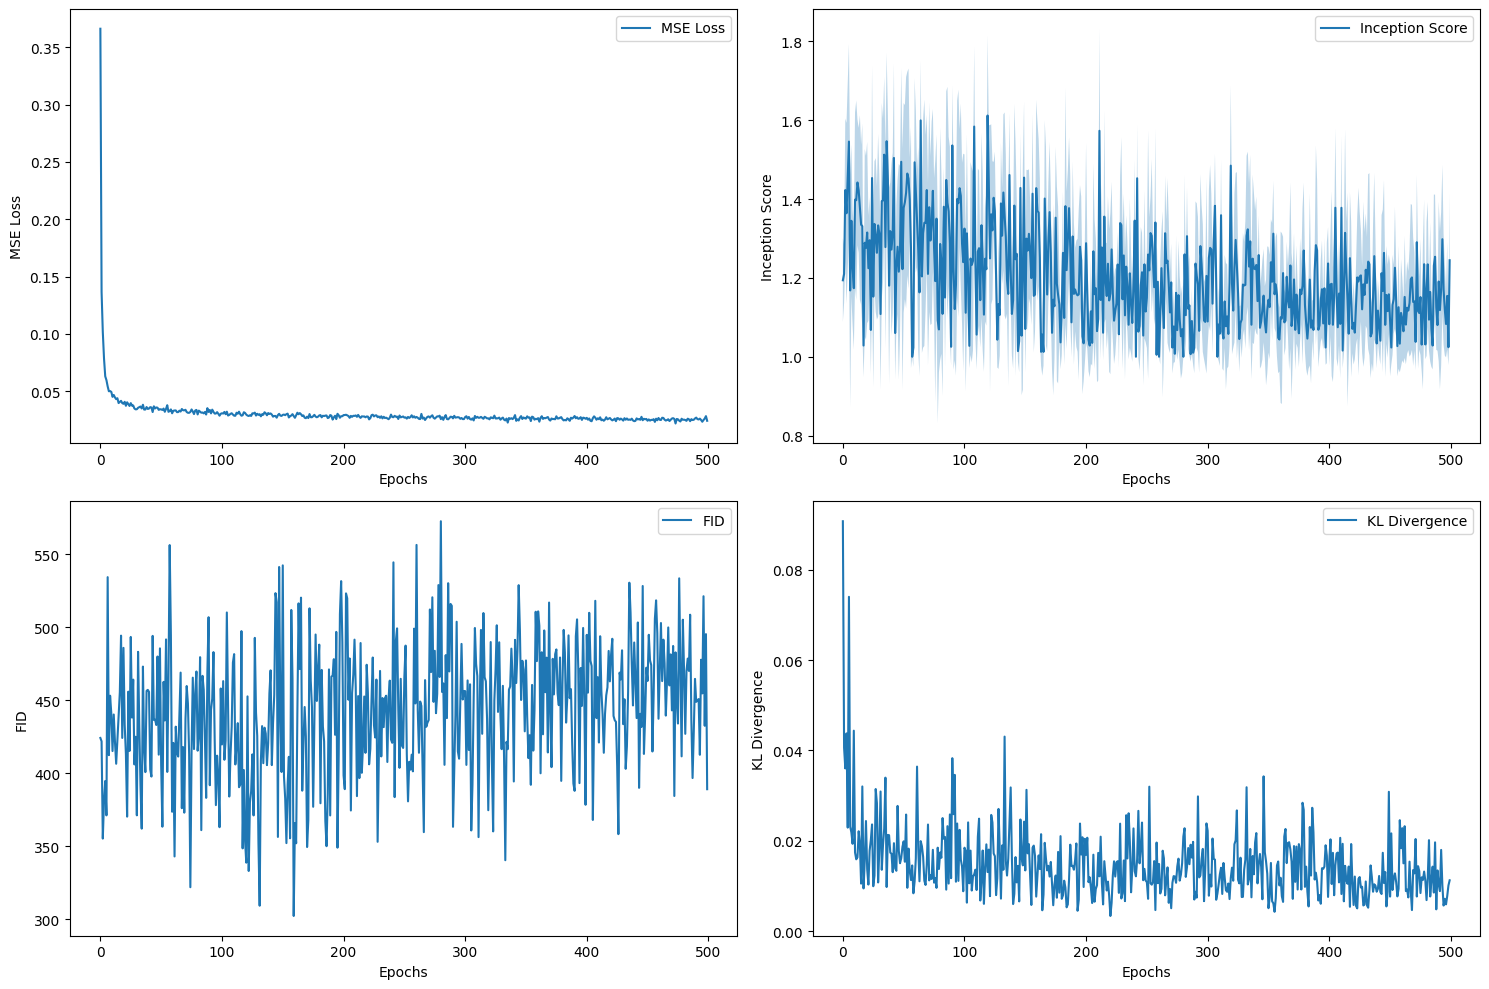

Final MSE Loss: 0.024307240465922014
Final Inception Score: 1.244788408279419 ± 0.1690097600221634
Final FID: 389.0674133300781
Final KL Divergence: 0.011284517124295235


In [ ]:
def launch():
    class Args:
        run_name = 'DDPM_conditional'
        epochs = 500
        batch_size = 32
        image_size = 24
        dataset_path = r"C:\Users\89304\OneDrive\桌面\9444data\car_resize_classified"
        device = 'cuda'
        lr = 3e-4
        num_classes = 25
    args = Args()
    train(args)
    
if __name__ == '__main__':
    launch()


# **Results Analysis**

MSE Loss：It can be seen that the MSE loss drops rapidly in the early stage, stabilizes after about 100 epochs, and maintains a low loss value during the final training process. The model gradually converges during the training process, and the stability of the loss function is at a low level, indicating that the model has the ability to perform on the training set.

Inception Score：IS has obvious fluctuations throughout the training process, but overall remains between 1.0 and 1.6. There are fluctuations throughout the training process, indicating that there are certain changes in the quality and diversity of the generated images. The final Inception Score is 1.2448, the error is 0.1690, and the overall trend is downward, indicating that the quality and diversity are decreasing.

FID：FID fluctuates greatly throughout the training process, remaining between 300 and 550, and the trend fluctuates greatly, and it is impossible to see an upward or downward trend.

# **Discussion** 

**Computational Limitations**: The primary limitation is the insufficient computational power, which restricts the number of training iterations and the resolution of generated images.

**Sample Quality**: High FID scores and low Inception Scores indicate that the sample quality is not yet on par with leading models.

**Training Time**: Due to limited resources, the training time is significantly less than required for achieving state-of-the-art results.

**Model Complexity**: The current model lacks some of the advanced features, such as adaptive group normalization and multi-resolution attention.

**Data lack for each class**: Because the amount of data for each class is very small, only 89 images, adding the category information to the model may cause the model to learn no useful information about the category


